# Coursera Capstone

## This notebook will be used for the Coursera Capstone Project - Battle_of_neighborhoods.
### _$Author: Diego Assis$_

## IMPORTS

In [1]:
#!pip install geopy
#!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt

##### *Creating a table using Wikipedia page*

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url, header=0)[0]
df.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

##### *At this time I am ignoring Borough with "Not assigned" value*

In [3]:
df.drop(df[df['Borough']=='Not assigned'].index,inplace=True)
df.reset_index(drop = True, inplace = True)
df.head()

Postcode           Borough     Neighbourhood
0      M3A        North York         Parkwoods
1      M4A        North York  Victoria Village
2      M5A  Downtown Toronto      Harbourfront
3      M5A  Downtown Toronto       Regent Park
4      M6A        North York  Lawrence Heights

##### *Just make sure that any "Not assigned" Neighborhood will receive the Borough value as per requirements*

In [4]:
df.loc[df['Neighbourhood'] == 'Not assigned','Neighbourhood'] = df['Borough']
print(df.loc[df['Neighbourhood'] == 'Not assigned'])

Empty DataFrame
Columns: [Postcode, Borough, Neighbourhood]
Index: []


##### *Whenever we have more than one row per postcode, we will concatenate all neighborhoods into a comma separated list*

In [5]:
foo = lambda a: ", ".join(a)
toronto_neighborhoods = df.groupby(df["Postcode"], sort = False).aggregate(
    {'Borough':'first', 'Neighbourhood': foo}).reset_index()

toronto_neighborhoods.head()

Postcode           Borough                     Neighbourhood
0      M3A        North York                         Parkwoods
1      M4A        North York                  Victoria Village
2      M5A  Downtown Toronto         Harbourfront, Regent Park
3      M6A        North York  Lawrence Heights, Lawrence Manor
4      M7A      Queen's Park                      Queen's Park

### *Assign geographical coordinates*

In [6]:
latlon = pd.read_csv("http://cocl.us/Geospatial_data")
latlon.rename(columns = {'Postal Code':'Postcode'},inplace = True)
latlon.head()

Postcode   Latitude  Longitude
0      M1B  43.806686 -79.194353
1      M1C  43.784535 -79.160497
2      M1E  43.763573 -79.188711
3      M1G  43.770992 -79.216917
4      M1H  43.773136 -79.239476

##### *Merge this dataset with our toronto_neighborhoods dataset from above*

In [7]:
toronto_neighborhoods = pd.merge(toronto_neighborhoods,latlon,on = 'Postcode', how = 'left')
toronto_neighborhoods.head()

Postcode           Borough                     Neighbourhood   Latitude  \
0      M3A        North York                         Parkwoods  43.753259   
1      M4A        North York                  Victoria Village  43.725882   
2      M5A  Downtown Toronto         Harbourfront, Regent Park  43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4      M7A      Queen's Park                      Queen's Park  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

### *Aditional Data*

##### *Number of Elementary and Secondary schools per postal code*

In [8]:
df = pd.read_excel('https://files.ontario.ca/opendata/publicly_funded_schools_xlsx_january_2019_en.xlsx')
df.head()

Region Board Number  Board Name  \
0  Sudbury-North Bay Regional Office       B28010  Algoma DSB   
1  Sudbury-North Bay Regional Office       B28010  Algoma DSB   
2  Sudbury-North Bay Regional Office       B28010  Algoma DSB   
3  Sudbury-North Bay Regional Office       B28010  Algoma DSB   
4  Sudbury-North Bay Regional Office       B28010  Algoma DSB   

               Board Type Board Language  School Number  \
0  Pub Dist Sch Brd (E/F)        English         902344   
1  Pub Dist Sch Brd (E/F)        English          19186   
2  Pub Dist Sch Brd (E/F)        English          67679   
3  Pub Dist Sch Brd (E/F)        English          43362   
4  Pub Dist Sch Brd (E/F)        English          54542   

                                    School Name School Level School Language  \
0  Algoma Education Connection Secondary School    Secondary         English   
1                     Anna McCrea Public School   Elementary         English   
2                Arthur Henderson Public School   Elementary         English   
3                  Ben R McMullin Public School   Elementary         English   
4                     Blind River Public School   Elementary         English   

  School Type       ...                   City Province Postal Code  \
0      Public       ...        Sault Ste Marie  Ontario      P6B4J4   
1      Public       ...        Sault Ste Marie  Ontario      P6A3M7   
2      Public       ...            Bruce Mines  Ontario      P0R1C0   
3      Public       ...        Sault Ste Marie  Ontario      P6B5K2   
4      Public       ...            Blind River  Ontario      P0R1B0   

          Phone           Fax Grade Range  Date Open School Email  \
0  705-945-7194  705-945-7173        9-12 2010-09-07          NaN   
1  705-945-7106  705-945-7221        JK-8 1969-09-01          NaN   
2  705-785-3483  705-785-3220        JK-3 1969-09-01          NaN   
3  705-945-7108  705-945-7205        JK-8 1969-09-01          NaN   
4  705-356-7752  705-356-0271        JK-8 1969-09-01          NaN   

                                      School Website   Board Website  
0                              http://www.adsb.on.ca  www.adsb.on.ca  
1  http://www.adsb.on.ca/sites/schools/amc/defaul...  www.adsb.on.ca  
2  http://www.adsb.on.ca/sites/schools/art/defaul...  www.adsb.on.ca  
3  http://www.adsb.on.ca/sites/schools/brm/defaul...  www.adsb.on.ca  
4  http://www.adsb.on.ca/sites/schools/bli/defaul...  www.adsb.on.ca  

[5 rows x 24 columns]

##### *We will remove the records where the post code is null and we have to filter for postal codes that begin with M - these are the Toronto postal codes. Additionally, we want to keep only public schools as these are the only ones that we are interested in.*

In [9]:
df = df[df['Postal Code'].notna()]
df = df[df['Postal Code'].str.startswith('M')]
df['Postal Code'] = df['Postal Code'].str[:3]
df = df[df['School Type'] == 'Public']
df['School Level'] = df['School Level'].apply(lambda x: x + ' School')

toronto_schools = df[['School Level', 'School Name', 'Postal Code']]
toronto_schools.head()

School Level                                 School Name Postal Code
540  Elementary School                Collège français élémentaire         M5B
541   Secondary School                 Collège français secondaire         M5B
542  Elementary School  École élémentaire Académie Alexandre-Dumas         M1E
546  Elementary School           École élémentaire Charles-Sauriol         M6N
551  Elementary School             École élémentaire Étienne-Brûlé         M2L

##### *Merging with the toronto_neighborhoods dataset.*

In [10]:
toronto_schools = toronto_schools.join(toronto_neighborhoods.set_index('Postcode'), on = 'Postal Code')
toronto_schools.head()

School Level                                 School Name  \
540  Elementary School                Collège français élémentaire   
541   Secondary School                 Collège français secondaire   
542  Elementary School  École élémentaire Académie Alexandre-Dumas   
546  Elementary School           École élémentaire Charles-Sauriol   
551  Elementary School             École élémentaire Étienne-Brûlé   

    Postal Code           Borough                      Neighbourhood  \
540         M5B  Downtown Toronto           Ryerson, Garden District   
541         M5B  Downtown Toronto           Ryerson, Garden District   
542         M1E       Scarborough  Guildwood, Morningside, West Hill   
546         M6N              York      The Junction North, Runnymede   
551         M2L        North York           Silver Hills, York Mills   

      Latitude  Longitude  
540  43.657162 -79.378937  
541  43.657162 -79.378937  
542  43.763573 -79.188711  
546  43.673185 -79.487262  
551  43.757490 -79.374714

In [11]:
toronto_schools_count = toronto_schools.groupby('Postal Code').count().reset_index()
toronto_schools_count.head()

Postal Code  School Level  School Name  Borough  Neighbourhood  Latitude  \
0         M1B            17           17       17             17        17   
1         M1C            10           10       10             10        10   
2         M1E            22           22       22             22        22   
3         M1G            12           12       12             12        12   
4         M1H             5            5        5              5         5   

   Longitude  
0         17  
1         10  
2         22  
3         12  
4          5

##### *Population count per postal code*

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/speelcraft/Coursera_Capstone/master/T120120190215054507.csv')
df = df[df['Geographic code'].str.startswith('M')]
df = df[df['Population, 2016'] > 99]
df = df[['Geographic code', 'Population, 2016', 'Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016']]
df.head()

Geographic code  Population, 2016  Total private dwellings, 2016  \
895             M1B             66108                          20957   
896             M1C             35626                          11588   
897             M1E             46943                          17637   
898             M1G             29690                          10116   
899             M1H             24383                           9274   

     Private dwellings occupied by usual residents, 2016  
895                                              20230    
896                                              11274    
897                                              17161    
898                                               9767    
899                                               8985

For the analysis, we are interested in residential areas and therefore we want to exclude tourists which means that our column of interest is Private dwellings occupied by usual residents, 2016. We will divide this number by the total population count to derive a percentage of residents as compared to the total population. In residential areas where most of the population is not made up of tourists, the percentage should be higher as elsewhere.

In [13]:
pct = df['Private dwellings occupied by usual residents, 2016'] / df['Population, 2016']
df.insert(df.shape[1], 'Percent Occupied', pct)
toronto_population = df.drop(['Population, 2016', 'Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'], 1)
toronto_population.head()

Geographic code  Percent Occupied
895             M1B          0.306014
896             M1C          0.316454
897             M1E          0.365571
898             M1G          0.328966
899             M1H          0.368494

##### *Create map of Toronto Neighbourhoods (FSAs) using retrived latitude and longitude values*

In [14]:
map_pop = folium.Map(location=[43.653963, -79.387207], zoom_start=10)

ontario_geo = "https://raw.githubusercontent.com/speelcraft/Coursera_Capstone/master/Toronto2.geojson"

folium.Choropleth(
    geo_data=ontario_geo,
    data = toronto_population,
    columns=['Geographic code','Percent Occupied'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Percent of private dwellings occupied by usual residents, 2016'
).add_to(map_pop)   
    
map_pop

Note: because GitHub doesn't display Folium maps, a print screen of the map is available <a href="https://github.com/Speelcraft/Coursera_Capstone/blob/master/MAP%201.JPG" target="_blank" title="Map1">here</a>

##### *Join population data with Toronto neighborhoods dataframe*

In [15]:
toronto_neighborhoods = toronto_neighborhoods.join(toronto_population.set_index('Geographic code'), on = 'Postcode')

toronto_neighborhoods['Percent Occupied'].fillna(0, inplace=True)
toronto_neighborhoods.head()

Postcode           Borough                     Neighbourhood   Latitude  \
0      M3A        North York                         Parkwoods  43.753259   
1      M4A        North York                  Victoria Village  43.725882   
2      M5A  Downtown Toronto         Harbourfront, Regent Park  43.654260   
3      M6A        North York  Lawrence Heights, Lawrence Manor  43.718518   
4      M7A      Queen's Park                      Queen's Park  43.662301   

   Longitude  Percent Occupied  
0 -79.329656          0.382522  
1 -79.315572          0.427197  
2 -79.360636          0.543673  
3 -79.464763          0.383599  
4 -79.389494          0.000000

### *Exploring with Foursquare*

##### *Define Foursquare Credentials and explore venues in 500 meters*

In [16]:
CLIENT_ID = 'UOBNWGJLDJ3YRS4EQDFLUE2WXCSQLRMX30NNKNFFDAFBGWWL'
CLIENT_SECRET = '0XL3VFU5O1C0G5EFCURHVD0HP3GYU1UFK4TVOACS20H2BSSL'
VERSION = '20180604'
LIMIT = 100 # limit of number of venues returned by Foursquare API

In [17]:
neighborhood_name = toronto_neighborhoods.loc[0, 'Neighbourhood']
neighborhood_latitude = toronto_neighborhoods.loc[0, 'Latitude']
neighborhood_longitude = toronto_neighborhoods.loc[0, 'Longitude']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [18]:
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [19]:
results = requests.get(url).json()

##### *I will create the get_category_type function which extracts the category name from a JSON object.*

In [20]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

venue.name      venue.categories  venue.location.lat  \
0  Brookbanks Park                  Park           43.751976   
1              KFC  Fast Food Restaurant           43.754387   
2   TTC stop #8380              Bus Stop           43.752672   
3    Variety Store     Food & Drink Shop           43.751974   

   venue.location.lng  
0          -79.332140  
1          -79.333021  
2          -79.326351  
3          -79.333114

##### *Now a similar get_category_type function which extracts the category name from a JSON object for all the neighborhoods.*

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names = toronto_neighborhoods['Postcode'],
                                   latitudes = toronto_neighborhoods['Latitude'],
                                   longitudes = toronto_neighborhoods['Longitude']
                                  )

M3A
M4A
M5A
M6A
M7A
M9A
M1B
M3B
M4B
M5B
M6B
M9B
M1C
M3C
M4C
M5C
M6C
M9C
M1E
M4E
M5E
M6E
M1G
M4G
M5G
M6G
M1H
M2H
M3H
M4H
M5H
M6H
M1J
M2J
M3J
M4J
M5J
M6J
M1K
M2K
M3K
M4K
M5K
M6K
M1L
M2L
M3L
M4L
M5L
M6L
M9L
M1M
M2M
M3M
M4M
M5M
M6M
M9M
M1N
M2N
M3N
M4N
M5N
M6N
M9N
M1P
M2P
M4P
M5P
M6P
M9P
M1R
M2R
M4R
M5R
M6R
M7R
M9R
M1S
M4S
M5S
M6S
M1T
M4T
M5T
M1V
M4V
M5V
M8V
M9V
M1W
M4W
M5W
M8W
M9W
M1X
M4X
M5X
M8X
M4Y
M7Y
M8Y
M8Z


In [24]:
print(toronto_venues.shape)
toronto_venues.head()

(2235, 7)


Postcode  Neighborhood Latitude  Neighborhood Longitude  \
0      M3A              43.753259              -79.329656   
1      M3A              43.753259              -79.329656   
2      M3A              43.753259              -79.329656   
3      M3A              43.753259              -79.329656   
4      M4A              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2          TTC stop #8380       43.752672       -79.326351   
3           Variety Store       43.751974       -79.333114   
4  Victoria Village Arena       43.723481       -79.315635   

         Venue Category  
0                  Park  
1  Fast Food Restaurant  
2              Bus Stop  
3     Food & Drink Shop  
4          Hockey Arena

In [25]:
toronto_venues_save = toronto_venues

##### *Here I have many postal codes with only a few venue categories. These postal codes have too little data to make a meaningful analysis, therefore I will exclude them from the dataset.*

In [26]:
toronto_venues_count = toronto_venues.groupby('Postcode').count().reset_index()
toronto_venues_count = toronto_venues_count[['Postcode', 'Venue Category']]
toronto_venues_count.columns = ['Postcode', 'Venue Category Count']

neigh_to_exclude = toronto_venues_count[toronto_venues_count['Venue Category Count'] < 5]

toronto_venues_filt = toronto_venues[~toronto_venues['Postcode'].isin(neigh_to_exclude)]
toronto_venues = toronto_venues_filt
toronto_venues.groupby('Postcode').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Postcode                                                         
M1B                           1                       1      1   
M1C                           2                       2      2   
M1E                           7                       7      7   
M1G                           4                       4      4   
M1H                           7                       7      7   
M1J                           1                       1      1   
M1K                           5                       5      5   
M1L                          10                      10     10   
M1M                           2                       2      2   
M1N                           4                       4      4   
M1P                           7                       7      7   
M1R                           6                       6      6   
M1S                           4                       4      4   
M1T                          11                      11     11   
M1V                           2                       2      2   
M1W                          12                      12     12   
M2H                           6                       6      6   
M2J                          65                      65     65   
M2K                           4                       4      4   
M2L                           1                       1      1   
M2N                          35                      35     35   
M2P                           3                       3      3   
M2R                           5                       5      5   
M3A                           4                       4      4   
M3B                           5                       5      5   
M3C                          20                      20     20   
M3H                          18                      18     18   
M3J                           4                       4      4   
M3K                           3                       3      3   
M3L                           6                       6      6   
...                         ...                     ...    ...   
M6B                           4                       4      4   
M6C                           4                       4      4   
M6E                           5                       5      5   
M6G                          16                      16     16   
M6H                          14                      14     14   
M6J                          65                      65     65   
M6K                          21                      21     21   
M6L                           4                       4      4   
M6M                           3                       3      3   
M6N                           4                       4      4   
M6P                          23                      23     23   
M6R                          15                      15     15   
M6S                          34                      34     34   
M7A                          39                      39     39   
M7R                          11                      11     11   
M7Y                          19                      19     19   
M8V                          15                      15     15   
M8W                           9                       9      9   
M8X                           3                       3      3   
M8Y                           3                       3      3   
M8Z                          14                      14     14   
M9B                           1                       1      1   
M9C                           8                       8      8   
M9L                           3                       3      3   
M9M                           2                       2      2   
M9N                           2                       2      2   
M9P                           8                       8      8   
M9R                           3                   

### *Analyze Each Neighborhood*

In [27]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#rename the column 'Neighborhood' which represents a category name to 'Neighborhood Category' 
#this is to distinguish this column from the 'Neighborhood' column which we want to continue to use as the neighborhood name
toronto_onehot.rename(columns={'Neighborhood':'Neighborhood Category'}, inplace=True)

# add neighborhood column back to dataframe
toronto_onehot['Postcode'] = toronto_venues['Postcode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [28]:
toronto_onehot.shape

(2235, 274)

##### *I will group all rows by neighborhood and by taking the mean of the frequency of occurrence of each category.*

In [29]:
toronto_grouped = toronto_onehot.groupby('Postcode').mean().reset_index()
toronto_grouped.head()

Postcode  Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0      M1B                0.0                0.0      0.0                 0.0   
1      M1C                0.0                0.0      0.0                 0.0   
2      M1E                0.0                0.0      0.0                 0.0   
3      M1G                0.0                0.0      0.0                 0.0   
4      M1H                0.0                0.0      0.0                 0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0                  0.0   
1             0.0              0.0               0.0                  0.0   
2             0.0              0.0               0.0                  0.0   
3             0.0              0.0               0.0                  0.0   
4             0.0              0.0               0.0                  0.0   

   Antique Shop     ...       Train Station  Vegetarian / Vegan Restaurant  \
0           0.0     ...                 0.0                            0.0   
1           0.0     ...                 0.0                            0.0   
2           0.0     ...                 0.0                            0.0   
3           0.0     ...                 0.0                            0.0   
4           0.0     ...                 0.0                            0.0   

   Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0               0.0          0.0                    0.0              0.0   
1               0.0          0.0                    0.0              0.0   
2               0.0          0.0                    0.0              0.0   
3               0.0          0.0                    0.0              0.0   
4               0.0          0.0                    0.0              0.0   

   Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0       0.0          0.0            0.0          0.0  
1       0.0          0.0            0.0          0.0  
2       0.0          0.0            0.0          0.0  
3       0.0          0.0            0.0          0.0  
4       0.0          0.0            0.0          0.0  

[5 rows x 274 columns]

In [30]:
toronto_grouped.shape

(100, 274)

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).to_frame().reset_index()
    row_cutoff = row_categories_sorted.head(num_top_venues)
    row_cutoff.columns = ['Venue', 'Appears']
    return_array = row_cutoff['Venue'].where(row_cutoff['Appears'] != 0, other = np.NaN, axis = 0)

    return return_array.values

##### *Now I create the new dataframe and display the top 10 venues for each neighborhood.*

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Postcode'] = toronto_grouped['Postcode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0      M1B  Fast Food Restaurant                   NaN                   NaN   
1      M1C        History Museum                   Bar                   NaN   
2      M1E        Breakfast Spot          Intersection   Rental Car Location   
3      M1G           Coffee Shop     Korean Restaurant     Indian Restaurant   
4      M1H  Caribbean Restaurant      Hakka Restaurant                Bakery   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2           Pizza Place     Electronics Store        Medical Center   
3                   NaN                   NaN                   NaN   
4                  Bank    Athletics & Sports       Thai Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2    Mexican Restaurant                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4   Fried Chicken Joint                   NaN                   NaN   

  10th Most Common Venue  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [33]:
neighborhoods_venues_sorted.groupby(['1st Most Common Venue']).size()

1st Most Common Venue
Airport Service               1
Bakery                        1
Bank                          1
Bar                           1
Baseball Field                1
Breakfast Spot                2
Bus Line                      1
Cafeteria                     1
Café                          6
Caribbean Restaurant          3
Clothing Store                1
Coffee Shop                  21
College Stadium               1
Dessert Shop                  1
Discount Store                1
Fast Food Restaurant          6
Food Truck                    1
Furniture / Home Store        2
Garden                        1
Gift Shop                     1
Greek Restaurant              1
Grocery Store                 3
Gym                           2
Gym / Fitness Center          1
History Museum                1
Indian Restaurant             2
Italian Restaurant            1
Jewelry Store                 1
Light Rail Station            2
Mexican Restaurant            1
Middle Eastern Res

### *Cluster Neighborhoods*

##### *Use k-means to cluster the neighborhood into 5 clusters.*

In [34]:
toronto_grouped = toronto_grouped.join(toronto_population.set_index('Geographic code'), on = 'Postcode')
toronto_grouped['Percent Occupied'].fillna(0, inplace=True)
toronto_grouped.head()

Postcode  Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0      M1B                0.0                0.0      0.0                 0.0   
1      M1C                0.0                0.0      0.0                 0.0   
2      M1E                0.0                0.0      0.0                 0.0   
3      M1G                0.0                0.0      0.0                 0.0   
4      M1H                0.0                0.0      0.0                 0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0                  0.0   
1             0.0              0.0               0.0                  0.0   
2             0.0              0.0               0.0                  0.0   
3             0.0              0.0               0.0                  0.0   
4             0.0              0.0               0.0                  0.0   

   Antique Shop        ...         Vegetarian / Vegan Restaurant  \
0           0.0        ...                                   0.0   
1           0.0        ...                                   0.0   
2           0.0        ...                                   0.0   
3           0.0        ...                                   0.0   
4           0.0        ...                                   0.0   

   Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0               0.0          0.0                    0.0              0.0   
1               0.0          0.0                    0.0              0.0   
2               0.0          0.0                    0.0              0.0   
3               0.0          0.0                    0.0              0.0   
4               0.0          0.0                    0.0              0.0   

   Wine Bar  Wings Joint  Women's Store  Yoga Studio  Percent Occupied  
0       0.0          0.0            0.0          0.0          0.306014  
1       0.0          0.0            0.0          0.0          0.316454  
2       0.0          0.0            0.0          0.0          0.365571  
3       0.0          0.0            0.0          0.0          0.328966  
4       0.0          0.0            0.0          0.0          0.368494  

[5 rows x 275 columns]

In [35]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Postcode', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods_venues_sorted
toronto_merged = toronto_merged.join(toronto_neighborhoods.set_index('Postcode'), on='Postcode')
toronto_merged.head()

Cluster Labels Postcode 1st Most Common Venue 2nd Most Common Venue  \
0               0      M1B  Fast Food Restaurant                   NaN   
1               0      M1C        History Museum                   Bar   
2               0      M1E        Breakfast Spot          Intersection   
3               2      M1G           Coffee Shop     Korean Restaurant   
4               0      M1H  Caribbean Restaurant      Hakka Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2   Rental Car Location           Pizza Place     Electronics Store   
3     Indian Restaurant                   NaN                   NaN   
4                Bakery                  Bank    Athletics & Sports   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2        Medical Center    Mexican Restaurant                   NaN   
3                   NaN                   NaN                   NaN   
4       Thai Restaurant   Fried Chicken Joint                   NaN   

  9th Most Common Venue 10th Most Common Venue      Borough  \
0                   NaN                    NaN  Scarborough   
1                   NaN                    NaN  Scarborough   
2                   NaN                    NaN  Scarborough   
3                   NaN                    NaN  Scarborough   
4                   NaN                    NaN  Scarborough   

                            Neighbourhood   Latitude  Longitude  \
0                          Rouge, Malvern  43.806686 -79.194353   
1  Highland Creek, Rouge Hill, Port Union  43.784535 -79.160497   
2       Guildwood, Morningside, West Hill  43.763573 -79.188711   
3                                  Woburn  43.770992 -79.216917   
4                               Cedarbrae  43.773136 -79.239476   

   Percent Occupied  
0          0.306014  
1          0.316454  
2          0.365571  
3          0.328966  
4          0.368494

##### *Visualize the resulting clusters.*

In [37]:
address = 'Toronto'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [38]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Note: because GitHub doesn't display Folium maps, a print screen of the map is available <a href="https://github.com/Speelcraft/Coursera_Capstone/blob/master/MAP%202.JPG" target="_blank" title="Map2">here</a>

### *Examine Clusters*

##### *Now I will examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.*

In [39]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['6th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['7th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['8th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['9th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['10th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)

    return df_cnt.head(10)

##### *Cluster 0: Residential*

In [40]:
toronto_cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
toronto_cluster0

Postcode      1st Most Common Venue  2nd Most Common Venue  \
0       M1B       Fast Food Restaurant                    NaN   
1       M1C             History Museum                    Bar   
2       M1E             Breakfast Spot           Intersection   
4       M1H       Caribbean Restaurant       Hakka Restaurant   
5       M1J                 Playground                    NaN   
7       M1L                   Bus Line                 Bakery   
8       M1M                      Motel    American Restaurant   
10      M1P          Indian Restaurant  Vietnamese Restaurant   
11      M1R  Middle Eastern Restaurant         Breakfast Spot   
13      M1T                Pizza Place         Breakfast Spot   
15      M1W       Fast Food Restaurant     Chinese Restaurant   
16      M2H       Fast Food Restaurant                Dog Run   
19      M2L                  Cafeteria                    NaN   
23      M3A       Fast Food Restaurant                   Park   
29      M3L              Grocery Store                   Park   
31      M3N       Gym / Fitness Center           Liquor Store   
33      M4B       Fast Food Restaurant            Pizza Place   
37      M4H          Indian Restaurant           Burger Joint   
46      M4T                 Restaurant           Tennis Court   
78      M6M       Fast Food Restaurant         Sandwich Place   
79      M6N                Pizza Place          Grocery Store   
90      M8Z                        Gym      Convenience Store   
93      M9L                Pizza Place    Empanada Restaurant   
94      M9M     Furniture / Home Store         Baseball Field   
96      M9P                Pizza Place            Coffee Shop   
98      M9V              Grocery Store            Coffee Shop   
99      M9W        Rental Car Location              Drugstore   

   3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0                    NaN                        NaN                   NaN   
1                    NaN                        NaN                   NaN   
2    Rental Car Location                Pizza Place     Electronics Store   
4                 Bakery                       Bank    Athletics & Sports   
5                    NaN                        NaN                   NaN   
7                   Park               Soccer Field           Bus Station   
8                    NaN                        NaN                   NaN   
10    Light Rail Station  Latin American Restaurant    Chinese Restaurant   
11           Auto Garage             Sandwich Place         Shopping Mall   
13          Noodle House         Italian Restaurant    Chinese Restaurant   
15           Coffee Shop              Grocery Store              Pharmacy   
16    Athletics & Sports   Mediterranean Restaurant           Golf Course   
19                   NaN                        NaN                   NaN   
23              Bus Stop          Food & Drink Shop                   NaN   
29                  Bank              Shopping Mall                 Hotel   
31         Grocery Store         Athletics & Sports                   NaN   
33             Pet Store         Athletics & Sports             Gastropub   
37           Yoga Studio                       Bank  Gym / Fitness Center   
46            Playground                        NaN                   NaN   
78        Discount Store                        NaN                   NaN   
79     Convenience Store                   Bus Line                   NaN   
90       Supplement Shop              Tanning Salon           Flower Shop   
93         Shopping Mall                        NaN                   NaN   
94                   NaN                        NaN                   NaN   
96          Intersection         Chinese Restaurant        Sandwich Place   
98        Discount Store        Japanese Restaurant        Sandwich Place   
99                   NaN                        NaN                   NaN   

        6th Most Common V

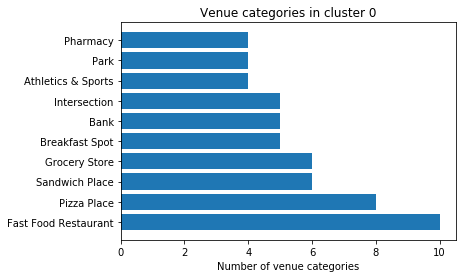

In [41]:
t0 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 0])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 0')
 
plt.show()

##### *Cluster 1: Downtown*

In [42]:
toronto_cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
toronto_cluster1

Postcode 1st Most Common Venue 2nd Most Common Venue  \
58      M5K           Coffee Shop                  Café   
59      M5L           Coffee Shop                 Hotel   
67      M5W           Coffee Shop            Restaurant   
68      M5X           Coffee Shop                  Café   
83      M7A           Coffee Shop                  Park   
84      M7R           Coffee Shop                 Hotel   
85      M7Y    Light Rail Station           Yoga Studio   

       3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
58                     Hotel            Restaurant                     Bakery   
59                      Café   American Restaurant                 Restaurant   
67                      Café    Seafood Restaurant         Italian Restaurant   
68                     Hotel            Restaurant                 Steakhouse   
83                       Gym                 Diner         Persian Restaurant   
84  Mediterranean Restaurant   Fried Chicken Joint  Middle Eastern Restaurant   
85             Auto Workshop                  Park                Pizza Place   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
58             Gastropub                   Gym    Italian Restaurant   
59             Gastropub                Bakery         Deli / Bodega   
67          Cocktail Bar              Beer Bar                 Hotel   
68                   Bar    Seafood Restaurant   American Restaurant   
83         Smoothie Shop    Seafood Restaurant          Burger Joint   
84        Sandwich Place   American Restaurant  Gym / Fitness Center   
85         Moving Target      Recording Studio            Restaurant   

   9th Most Common Venue 10th Most Common Venue           Borough  \
58                   Bar    American Restaurant  Downtown Toronto   
59            Steakhouse                    Gym  Downtown Toronto   
67                Bakery               Creperie  Downtown Toronto   
68                   Gym              Gastropub  Downtown Toronto   
83        Sandwich Place          Burrito Place      Queen's Park   
84         Burrito Place                    NaN       Mississauga   
85         Burrito Place             Skate Park      East Toronto   

                                        Neighbourhood   Latitude  Longitude  \
58           Design Exchange, Toronto Dominion Centre  43.647177 -79.381576   
59                     Commerce Court, Victoria Hotel  43.648198 -79.379817   
67                    Stn A PO Boxes 25 The Esplanade  43.646435 -79.374846   
68             First Canadian Place, Underground city  43.648429 -79.382280   
83                                       Queen's Park  43.662301 -79.389494   
84              Canada Post Gateway Processing Centre  43.636966 -79.615819   
85  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558   

    Percent Occupied  
58               0.0  
59               0.0  
67               0.0  
68               0.0  
83               0.0  
84               0.0  
85               0.0

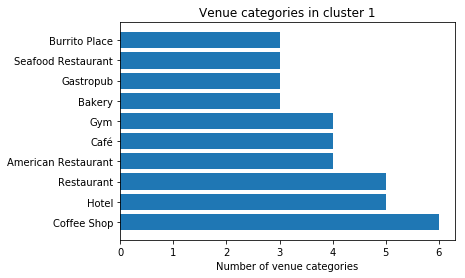

In [43]:
t1 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t1['Venue Category']))
plt.barh(y_pos, t1['Venue Count'], align='center')
plt.yticks(y_pos, t1['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()

##### *Cluster 2: Quick eats*

In [44]:
toronto_cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
toronto_cluster2

Postcode   1st Most Common Venue          2nd Most Common Venue  \
3       M1G             Coffee Shop              Korean Restaurant   
6       M1K          Discount Store             Chinese Restaurant   
9       M1N         College Stadium                           Café   
12      M1S          Breakfast Spot                 Clothing Store   
17      M2J          Clothing Store           Fast Food Restaurant   
18      M2K                    Café             Chinese Restaurant   
20      M2N             Coffee Shop               Ramen Restaurant   
22      M2R                Pharmacy                    Pizza Place   
24      M3B    Caribbean Restaurant           Gym / Fitness Center   
25      M3C                     Gym                     Beer Store   
26      M3H             Coffee Shop                  Shopping Mall   
27      M3J    Caribbean Restaurant                 Massage Studio   
30      M3M              Food Truck                 Baseball Field   
32      M4A             Coffee Shop     Financial or Legal Service   
34      M4C            Skating Rink                    Curling Ice   
35      M4E                   Trail              Health Food Store   
36      M4G             Coffee Shop            Sporting Goods Shop   
39      M4K        Greek Restaurant                    Coffee Shop   
40      M4L                    Park                 Sandwich Place   
41      M4M                    Café                    Coffee Shop   
43      M4P                    Park                 Clothing Store   
44      M4R     Sporting Goods Shop                    Coffee Shop   
45      M4S            Dessert Shop                 Sandwich Place   
47      M4V      Light Rail Station                    Coffee Shop   
49      M4X             Coffee Shop                            Pub   
50      M4Y             Coffee Shop            Japanese Restaurant   
51      M5A             Coffee Shop                           Park   
52      M5B             Coffee Shop                 Clothing Store   
53      M5C                    Café                          Hotel   
54      M5E             Coffee Shop                   Cocktail Bar   
55      M5G             Coffee Shop                 Ice Cream Shop   
56      M5H             Coffee Shop                           Café   
57      M5J             Coffee Shop                          Hotel   
60      M5M      Italian Restaurant                    Coffee Shop   
62      M5P           Jewelry Store               Sushi Restaurant   
63      M5R          Sandwich Place                           Café   
64      M5S                    Café                            Bar   
65      M5T                    Café  Vegetarian / Vegan Restaurant   
66      M5V         Airport Service                 Airport Lounge   
69      M6A  Furniture / Home Store                    Event Space   
73      M6G           Grocery Store                           Café   
74      M6H                  Bakery                       Pharmacy   
75      M6J                     Bar                    Coffee Shop   
76      M6K             Coffee Shop                           Café   
80      M6P      Mexican Restaurant                           Café   
81      M6R               Gift Shop                 Breakfast Spot   
82      M6S             Coffee Shop                           Café   
86      M8V                    Café                            Gym   
87      M8W             Pizza Place                            Gym   
89      M8Y          Baseball Field                   Home Service   
91      M9B                    Bank                            NaN   
92      M9C               Pet Store              Convenience Store   

    3rd Most Common Venue      4th Most Common Venue   5th Most Common Venue  \
3       Indian Restaurant                        NaN                     NaN   
6        Department Store                Coffee Shop             Bus Station   
9   General Entertainment               Skating Rink

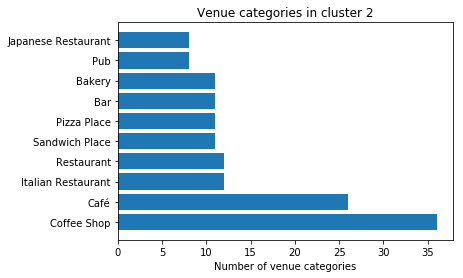

In [45]:
t2 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 2])

y_pos = np.arange(len(t2['Venue Category']))
plt.barh(y_pos, t2['Venue Count'], align='center')
plt.yticks(y_pos, t2['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 2')
 
plt.show()

##### *Cluster 3: Park*

In [46]:
toronto_cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
toronto_cluster3

Postcode 1st Most Common Venue       2nd Most Common Venue  \
14      M1V            Playground                        Park   
21      M2P                  Park                        Bank   
28      M3K                  Park                     Airport   
38      M4J                  Park                 Pizza Place   
42      M4N                  Park                 Swim School   
48      M4W                  Park                       Trail   
70      M6B                  Park         Japanese Restaurant   
71      M6C                  Park                       Field   
72      M6E                  Park        Fast Food Restaurant   
77      M6L                  Park  Construction & Landscaping   
88      M8X                 River                        Park   
95      M9N                  Park           Convenience Store   
97      M9R           Pizza Place                        Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
14                   NaN                   NaN                   NaN   
21     Convenience Store                   NaN                   NaN   
28            Playground                   NaN                   NaN   
38     Convenience Store                   NaN                   NaN   
42              Bus Line                   NaN                   NaN   
48            Playground              Building                   NaN   
70      Asian Restaurant                   Pub                   NaN   
71          Hockey Arena                 Trail                   NaN   
72         Women's Store                Market                   NaN   
77                Bakery      Basketball Court                   NaN   
88                  Pool                   NaN                   NaN   
95                   NaN                   NaN                   NaN   
97              Bus Line                   NaN                   NaN   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
14                   NaN                   NaN                   NaN   
21                   NaN                   NaN                   NaN   
28                   NaN                   NaN                   NaN   
38                   NaN                   NaN                   NaN   
42                   NaN                   NaN                   NaN   
48                   NaN                   NaN                   NaN   
70                   NaN                   NaN                   NaN   
71                   NaN                   NaN                   NaN   
72                   NaN                   NaN                   NaN   
77                   NaN                   NaN                   NaN   
88                   NaN                   NaN                   NaN   
95                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

   9th Most Common Venue 10th Most Common Venue           Borough  \
14                   NaN                    NaN       Scarborough   
21                   NaN                    NaN        North York   
28                   NaN                    NaN        North York   
38                   NaN                    NaN         East York   
42                   NaN                    NaN   Central Toronto   
48                   NaN                    NaN  Downtown Toronto   
70                   NaN                    NaN        North York   
71                   NaN                    NaN              York   
72                   NaN                    NaN              York   
77                   NaN                    NaN        North York   
88                   NaN                    NaN         Etobicoke   
95                   NaN                    NaN              York   
97                   NaN                    NaN         Etobicoke   

                                        Neighbourhood   Latitude  Longitude  \
14  Agincourt North, L'Amore

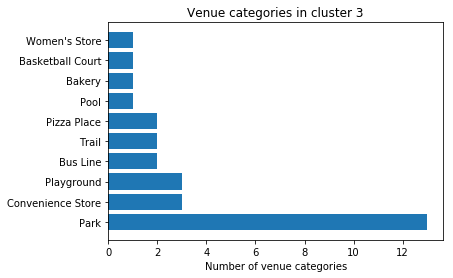

In [47]:
t3 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 3])

y_pos = np.arange(len(t3['Venue Category']))
plt.barh(y_pos, t3['Venue Count'], align='center')
plt.yticks(y_pos, t3['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 3')
 
plt.show()

##### *Cluster 4: Gardens*

In [48]:
toronto_cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
toronto_cluster4

Postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
61      M5N                Garden                   NaN                   NaN   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
61                   NaN                   NaN                   NaN   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
61                   NaN                   NaN                   NaN   

   10th Most Common Venue          Borough Neighbourhood   Latitude  \
61                    NaN  Central Toronto      Roselawn  43.711695   

    Longitude  Percent Occupied  
61 -79.416936          0.390488

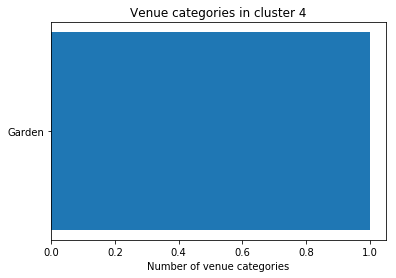

In [49]:
t4 = total_venue_categories(toronto_merged[toronto_merged['Cluster Labels'] == 4])

y_pos = np.arange(len(t4['Venue Category']))
plt.barh(y_pos, t4['Venue Count'], align='center')
plt.yticks(y_pos, t4['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 4')
 
plt.show()

## *Discussion*

Among the above clusters it would appear that the following clusters are best suited for families with children:

    Cluster 0: Residential. Venue categories in this cluster are predominantly shops with some interspersed coffee shops and restaurants as well as parks and sporting venues which is all suitable for families.
    
    Cluster 2: Quick eats. Venue categories in this cluster appear to be predominantly fast food restaurands, coffee shops, sandwich places, pizza places, grocery stores which all suggests places where one can find something quick to eat. These types of places are often located in shopping malls which suggest residential areas.

Let's do some analysis to verify these observations.

Check the average percent of private dwellings occupied by usual residents in each cluster.

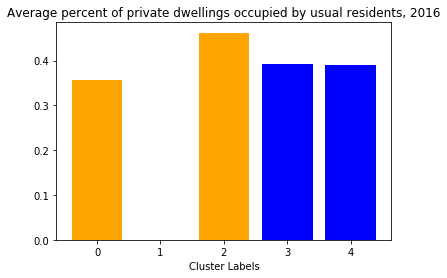

Cluster Labels  Percent Occupied
0               0          0.357594
1               1          0.000000
2               2          0.462011
3               3          0.392417
4               4          0.390488

In [50]:
tp = toronto_merged.groupby(['Cluster Labels']).mean().reset_index().drop(['Latitude', 'Longitude'], 1)

plt.bar(tp['Cluster Labels'], tp['Percent Occupied'], align='center', color = ['orange', 'blue', 'orange', 'blue', 'blue'])
plt.xlabel('Cluster Labels')
plt.title('Average percent of private dwellings occupied by usual residents, 2016')
 
plt.show()
tp

We would expect that clusters 0 and 2 that we have identified as best suited for families with children would have a higher percent occupied than other neighborhoods but in our case this is only approximately so. Cluster 2 does have the highest percent occupied value, but cluster 1 is outranked by cluster 3 and 4 which according to our segmentation is mostly made up of parks and gardens where we would not expect many residents to live.

A possible explanation is that the neighborhoods with parks are suburban areas with private houses but without many venues such as restaurants and shops and for this reason they are not representative of the data that was used. Further analysis of this result is suggested.

## *Best Toronto neighborhoods for families with children*

I have collected data from several blogs using the google search term "best toronto neighborhoods for families with children". I used the top search results and manually collected the names of suggested neighborhoods and stored them into an Excel file.

In [51]:
toronto_flagged = pd.read_excel('https://github.com/Speelcraft/Coursera_Capstone/blob/master/Top_blogs.xlsx?raw=true')
toronto_flagged.head()

Postal Code  TopFamilyFlag
0         M5N              1
1         M2K              1
2         M5M              1
3         M6S              1
4         M6H              1

In [52]:
tf = toronto_flagged.join(toronto_merged.set_index('Postcode'), on = 'Postal Code')
tf = tf[~tf['Cluster Labels'].isna()]
tf['Cluster Labels'] = tf['Cluster Labels'].astype(int)
tf.head()

Postal Code  TopFamilyFlag  Cluster Labels 1st Most Common Venue  \
0         M5N              1               4                Garden   
1         M2K              1               2                  Café   
2         M5M              1               2    Italian Restaurant   
3         M6S              1               2           Coffee Shop   
4         M6H              1               2                Bakery   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   NaN                   NaN                   NaN   
1    Chinese Restaurant                  Bank   Japanese Restaurant   
2           Coffee Shop         Grocery Store       Thai Restaurant   
3                  Café      Sushi Restaurant    Italian Restaurant   
4              Pharmacy           Supermarket  Gym / Fitness Center   

  5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
0                   NaN                        NaN                   NaN   
1                   NaN                        NaN                   NaN   
2          Liquor Store       Fast Food Restaurant        Sandwich Place   
3             Bookstore         Falafel Restaurant                   Bar   
4           Music Venue  Middle Eastern Restaurant                  Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0                   NaN                   NaN                    NaN   
1                   NaN                   NaN                    NaN   
2             Juice Bar               Butcher                   Café   
3                  Food     Fish & Chips Shop               Boutique   
4               Brewery                   Bar                   Bank   

           Borough                      Neighbourhood   Latitude  Longitude  \
0  Central Toronto                           Roselawn  43.711695 -79.416936   
1       North York                    Bayview Village  43.786947 -79.385975   
2       North York  Bedford Park, Lawrence Manor East  43.733283 -79.419750   
3     West Toronto                 Runnymede, Swansea  43.651571 -79.484450   
4     West Toronto       Dovercourt Village, Dufferin  43.669005 -79.442259   

   Percent Occupied  
0          0.390488  
1          0.441892  
2          0.362194  
3          0.427272  
4          0.427341

Add markers for the suggested neighborhoods to the previous map with clusters

In [53]:
for lat, lon, neigh, flg in zip(tf['Latitude'], tf['Longitude'], tf['Neighbourhood'], tf['TopFamilyFlag']):
    label = folium.Popup(neigh, parse_html=True)
    folium.Marker(
    [lat, lon],
    popup=label).add_to(map_clusters)
       
map_clusters

Note: because GitHub doesn't display Folium maps, a print screen of the map is available <a href="https://github.com/Speelcraft/Coursera_Capstone/blob/master/MAP%203.JPG" target="_blank" title="Map3">here</a>

In [54]:
tfg = tf[['Postal Code', 'Cluster Labels', 'Neighbourhood']]
tfg.groupby('Cluster Labels').count()

Postal Code  Neighbourhood
Cluster Labels                            
0                         3              3
2                        14             14
3                         1              1
4                         1              1

It appears that most of the neighborhoods that were suggested as best neighborhoods for families with children are located in clusters 0 and 2 which we have previously identified as most suitable clusters for families with children.

The recommendation for families with children who are looking for a neighborhood to move to in Toronto would be to look for places in clusters 0 and 2, in addition to those that have been suggested on blogs.

## *Comparing with school data*

Finally, we want to check our assumption that neighborhoods that are best for families with children are those with a higher number of public elementary and secondary schools. It turns this is not the case, as can be seen on the below map where a choropleth map with number of schools per postal code is superimposed on the above map.

A possible explanation might be that we are only looking at public schools. It is possible that private schools are more desirable but this would have to be examined further.

In [55]:
#ontario_geo = "https://raw.githubusercontent.com/speelcraft/Coursera_Capstone/master/data/Toronto2.geojson"

folium.Choropleth(
    geo_data=ontario_geo,
    data = toronto_schools_count,
    columns=['Postal Code','School Level'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of schools per postal code'
).add_to(map_clusters)     

map_clusters

Note: because GitHub doesn't display Folium maps, a print screen of the map is available <a href="https://github.com/Speelcraft/Coursera_Capstone/blob/master/MAP%204.JPG" target="_blank" title="Map4">here</a>